In [1]:
%run ../modules.ipynb

sys.path.append('../0. kernel-tutorials/')
# Local Utilities for Notebook
from utilities.kernels import linear_kernel, gaussian_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
cmaps = get_cmaps()
plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

n_FPS=2000
n_frames=50000
n_PC=5

In [2]:
all_frames=read('3cdc.xyz', index=':')

In [3]:
idx = np.random.randint(0, len(all_frames), n_frames) 
my_frames= [all_frames[i] for i in idx]

In [4]:
fcc=np.zeros(len(my_frames))
fcc_red=np.zeros(len(my_frames))
packing=np.zeros(len(my_frames))
n_species=np.zeros(len(my_frames))
cn=np.zeros(len(my_frames))
alpha=np.zeros(len(my_frames))
x=np.zeros(len(my_frames))
std_ratio=np.zeros(len(my_frames))
magic=np.zeros(len(my_frames))
natoms=np.zeros(len(my_frames))
hcp=np.zeros(len(my_frames))
hcp_red=np.zeros(len(my_frames))
red_frame=[]

In [5]:
for i, k in zip(my_frames, range(len(my_frames))):
    i.wrap(eps=1e-10)
    natoms[k]=len(i)
    if len(i)%4==0:
        magic[k]=1
    else:
        magic[k]=0
    frame_py=get_pymatgen(i)
    v=i.get_volume()  #unit = A^^3
    el=i.get_chemical_symbols()
    n_species[k]=(len(np.unique(el)))
    rad=get_r(el)
    indexes = [i for i,x in enumerate(rad) if x == max(i for i in rad if i is not None)]
    max_el=np.array(i.get_chemical_symbols())[indexes]
    max_pos=np.array(i.get_positions())[indexes]
    new=Atoms(max_el, positions=max_pos, pbc=True, cell=i.get_cell())
    red_frame.append(new)
    sg_red=(ase.spacegroup.get_spacegroup(new, symprec=1e-05))
    sg=ase.spacegroup.get_spacegroup(i, symprec=1e-05)
    if 220<sg.no<231:
        fcc[k]=int(1)
    if 190<sg.no<195:
        hcp[k]=int(1)
    if 220<sg_red.no<231:
        fcc_red[k]=int(1)
    if 190<sg_red.no<195:
        hcp_red[k]=int(1)
    v_atom=sum([(4/3)*pi*(rad[i]/100)**3 for i in range(len(rad))])
    nn=np.zeros(len(el))
    for l in range(len(el)):   
        try:
            nn[l]=CrystalNN(weighted_cn=False, distance_cutoffs=None, x_diff_weight=0.0,
                    porous_adjustment=False).get_cn(frame_py, l)
        except:
            pass
    cn[k]=nn.mean()
    rad=np.array(rad)
    n_s=np.count_nonzero(rad == np.min(rad))
    n_l=np.count_nonzero(rad == np.max(rad))
    alpha[k]=np.min(rad)/np.max(rad)
    x[k]=n_s/(n_s+n_l)
    std_ratio[k]=np.std(rad)
    packing[k]=v_atom/v

In [6]:
explore={r'FCC$_{tot}$':fcc, r'FCC$_{red}$':fcc_red,r'HCP$_{tot}$':hcp, r'HCP$_{red}$':hcp_red, 
    r'$N_{atoms,cell}$': natoms,
       'magic':magic} 
df= pd.DataFrame(explore)

In [7]:
print('total structure: between HCP, '+str(len(df.loc[((df['magic']==1) & (df[r'HCP$_{tot}$']==1))])/len(df.loc[((df[r'HCP$_{tot}$']==1))]))+' percent are magic, reduced structure: between HCP, '+str(len(df.loc[((df['magic']==1) & (df[r'HCP$_{red}$']==1))])/len(df.loc[((df[r'HCP$_{red}$']==1))]))+' percent are magic', 
'total structure: between FCC, '+str(len(df.loc[((df['magic']==1) & (df[r'FCC$_{tot}$']==1))])/len(df.loc[((df[r'FCC$_{tot}$']==1))]))+' percent are magic, reduced structure: between FCC, '+str(len(df.loc[((df['magic']==1) & (df[r'FCC$_{red}$']==1))])/len(df.loc[((df[r'FCC$_{red}$']==1))]))+' percent are magic')

total structure: between HCP, 0.4904862579281184 percent are magic, reduced structure: between HCP, 0.453804347826087 percent are magic total structure: between FCC, 0.3236607142857143 percent are magic, reduced structure: between FCC, 0.3479036574487065 percent are magic


In [12]:
frames_relax_tot=np.copy(my_frames)
magic=[]
len(frames_relax_tot), type(frames_relax_tot[0])
for frame in frames_relax_tot:
    frame.wrap(eps=1e-12)
    if len(frame) %4==0:
        magic.append(1)
    else:
        magic.append(0)

In [13]:
species = list(set([int(n) for frame in frames_relax_tot for n in frame.numbers]))

hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=3.5,
    max_radial=4,
    max_angular=4,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.5,
    cutoff_smooth_width=0.5,
    global_species=species,
    expansion_by_species_method="user defined",
    normalize=False
)

fps_soap = SOAP(
    **hypers,
)


In [14]:

idx_for_fps = np.random.randint(0, len(frames_relax_tot), n_FPS) 
frames_for_fps = [frames_relax_tot[i] for i in idx_for_fps]
X_temp = np.array(
    [
        np.mean(fps_soap.transform([frame]).get_features(fps_soap), axis=0)
        for frame in frames_for_fps
    ]
)

THRESH = 1e-12
high_var_features = np.where(np.var(X_temp - X_temp.mean(axis=0), axis=0) > THRESH)[0]
X_temp = X_temp[:, high_var_features]

X_raw = StandardFlexibleScaler(column_wise=False).fit_transform(X_temp)
del X_temp # save on memory

fps = FPS(n_FPS).fit(X_raw)
del X_raw 
u_species = np.unique(species)
sp_pairs = fps_soap.get_keys(u_species)

coefficient_subselection = np.zeros((n_FPS, 5))
index_mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"] + 1
)
for fi, i in enumerate(high_var_features[fps.selected_idx_]):
    coefficient_subselection[fi] = [
        index_mapping[i][k] for k in ["a", "b", "n1", "n2", "l"]
    ]
coefficient_subselection_dict = {
    "a": coefficient_subselection[:, 0].tolist(),
    "b": coefficient_subselection[:, 1].tolist(),
    "n1": coefficient_subselection[:, 2].tolist(),
    "n2": coefficient_subselection[:, 3].tolist(),
    "l": coefficient_subselection[:, 4].tolist(),
}

soap = SOAP(**hypers, coefficient_subselection=coefficient_subselection_dict)
X_raw = np.zeros((len(my_frames), n_FPS))
for fi, frame in enumerate(my_frames):
    X_raw[fi] = np.mean(soap.transform([frame]).get_features(soap), axis=0)

In [15]:
file=np.savez('../datasets/3dcd_soap'+str(n_frames)+'.npz', my_frames=my_frames, magic=magic, X_raw=X_raw)
#               cn=cn,n_species=n_species,
#  natoms=natoms,fcc=fcc, hcp=hcp, 
# packing=packing,alpha=alpha, x=x, std_ratio=std_ratio)

/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [12]:
npzfile = np.load('../datasets/3dcd_PCA_soap'+str(n_frames)+'.npz', allow_pickle=True)

my_frames=npzfile['my_frames']
natoms=npzfile['natoms']
magic=npzfile['magic']

std_ratio=npzfile['std_ratio']
n_species=npzfile['n_species']
alpha=npzfile['alpha']
x=npzfile['x']
cn=npzfile['cn']
packing=npzfile['packing']
fcc=npzfile['fcc']
hcp=npzfile['hcp']
X_raw=npzfile['X_raw']

In [13]:
dict={r'$\alpha$':alpha,r'$x$':x, r'$\sigma_{radii}$':std_ratio,
    r'$CN_{avg}$':cn, r'$N_{atoms,cell}$': natoms, r'$PF$':packing,
'magic':magic,  r'$N_{species}$': n_species, 'FCC':fcc, 'HCP':hcp}
df= pd.DataFrame(dict)

array([  8.        ,   7.92592593,   3.42857143, ...,  10.66666667,
         9.375     ,   4.4       ])

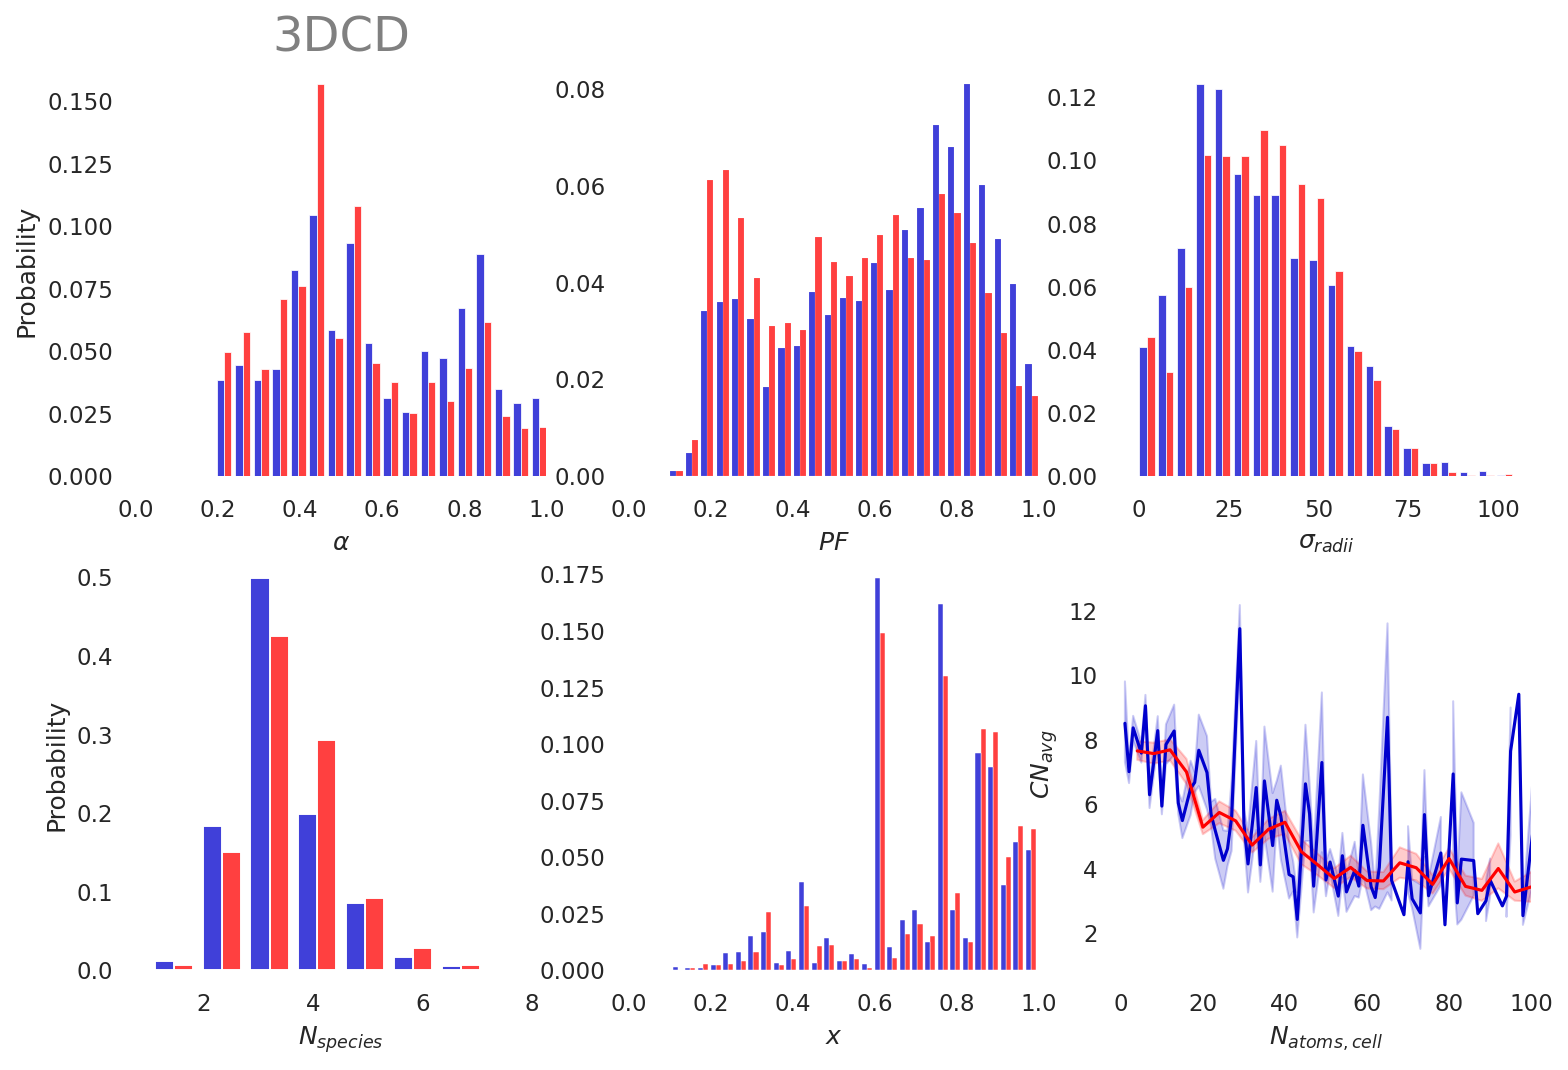

In [16]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

sns.histplot(ax=axes[0][0], data=df, x=r'$\alpha$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=20)
axes[0][0].set_xlim(0,1)
axes[0][0].set_title('3DCD', fontsize=23, color='grey')
sns.histplot(ax=axes[0][1], data=df, x=r'$PF$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8)

axes[0][1].set_ylabel(None)

axes[0][1].set_xlim(0,1)
sns.histplot(ax=axes[0][2], data=df, x=r'$\sigma_{radii}$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=20)
axes[0][2].set_ylabel(None)
sns.histplot(ax=axes[1][0], data=df, x=r'$N_{species}$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=int(max(n_species)))
sns.histplot(ax=axes[1][1], data=df, x=r'$x$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8)
axes[1][1].set_ylabel(None)
axes[1][1].set_xlim(0,1)
sns.lineplot(ax=axes[1][2], data=df, x=r'$N_{atoms,cell}$', y=r'$CN_{avg}$', hue='magic', legend=False)

axes[1][2].set_xlim(0,100)

sns.despine(left=True, bottom=True)

In [17]:
titles=[r'$\alpha$', 'x', 'PF', r'$CN_{avg}$']
quantity=[alpha, x, packing, cn]
alphas=np.logspace(-0, -6, 30)
ridgecv = RidgeCV(cv=4,fit_intercept=False, alphas=alphas)
pcovr = PCovR(mixing=mix[g],
                  n_components=n_PC)

<ipython-input-18-44bc4f63f00c>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes(axes=axM)


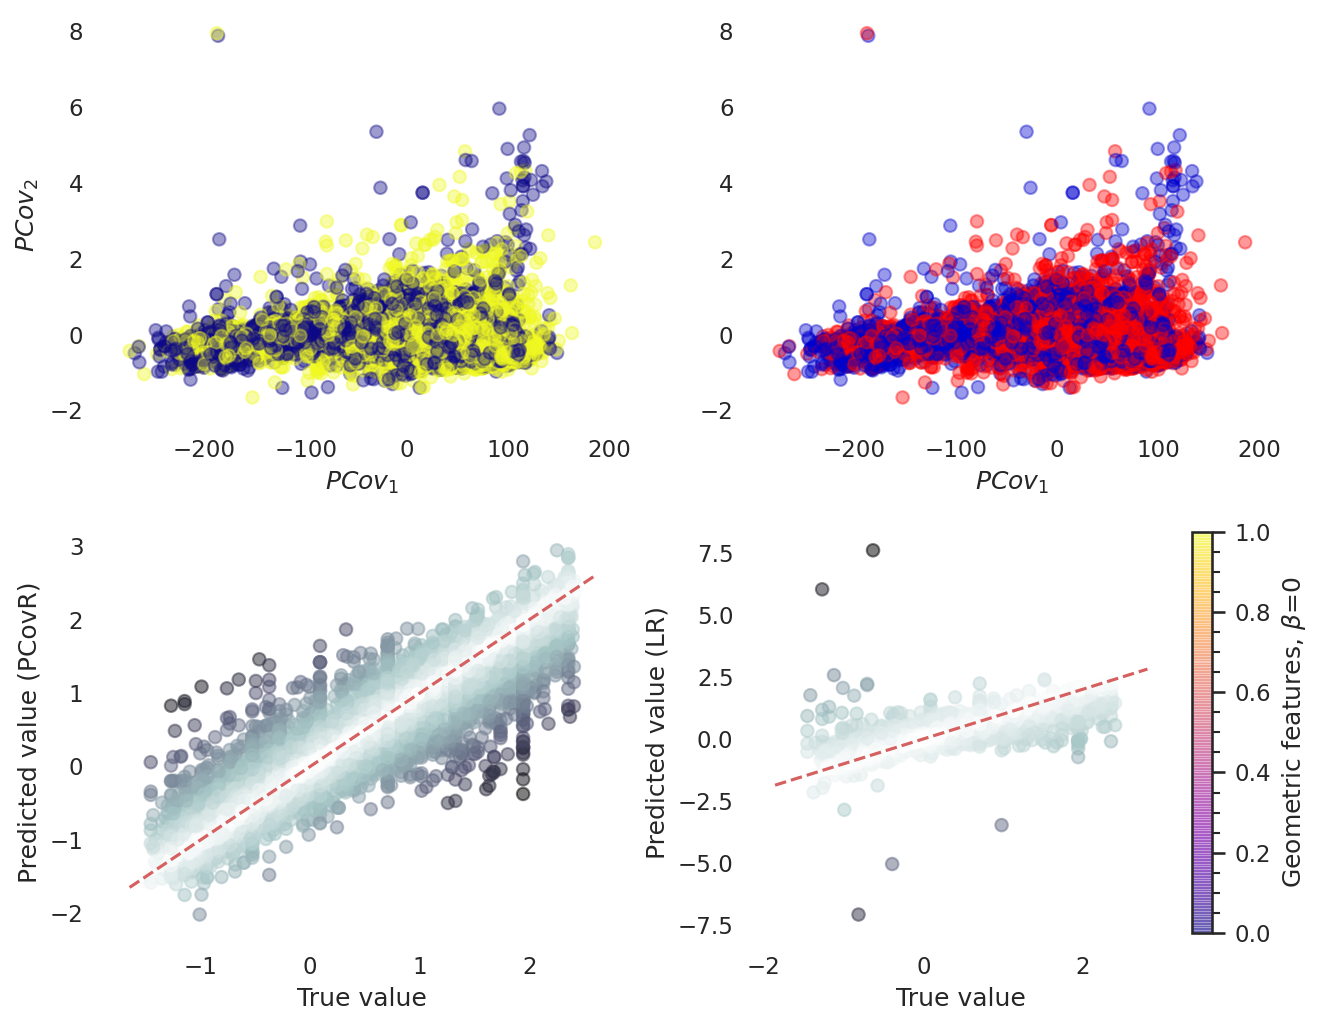

<ipython-input-18-44bc4f63f00c>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes(axes=axM)


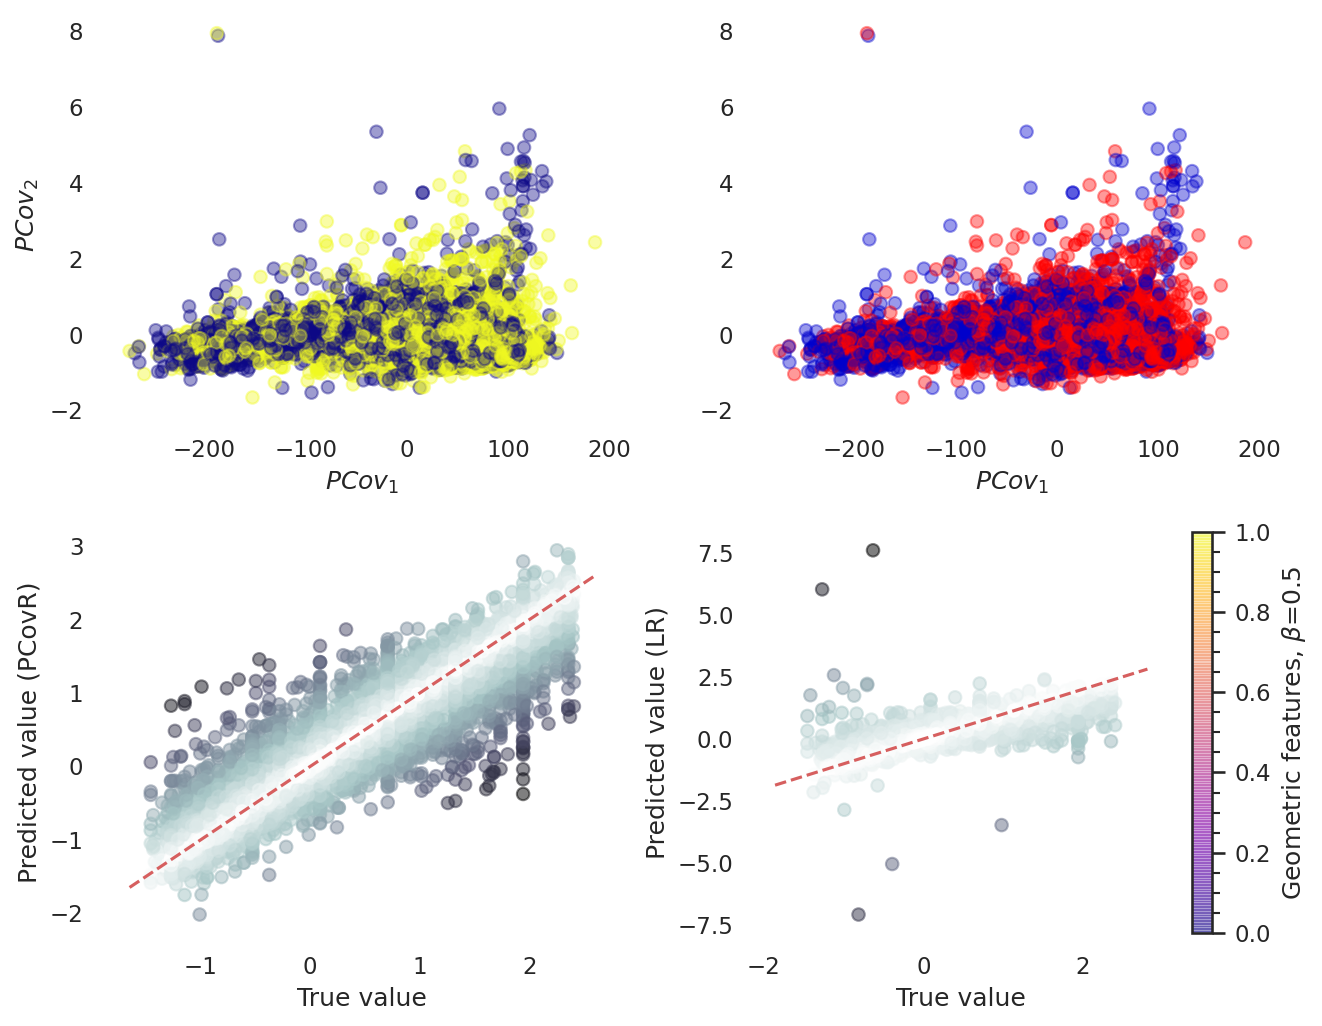

<ipython-input-18-44bc4f63f00c>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes(axes=axM)


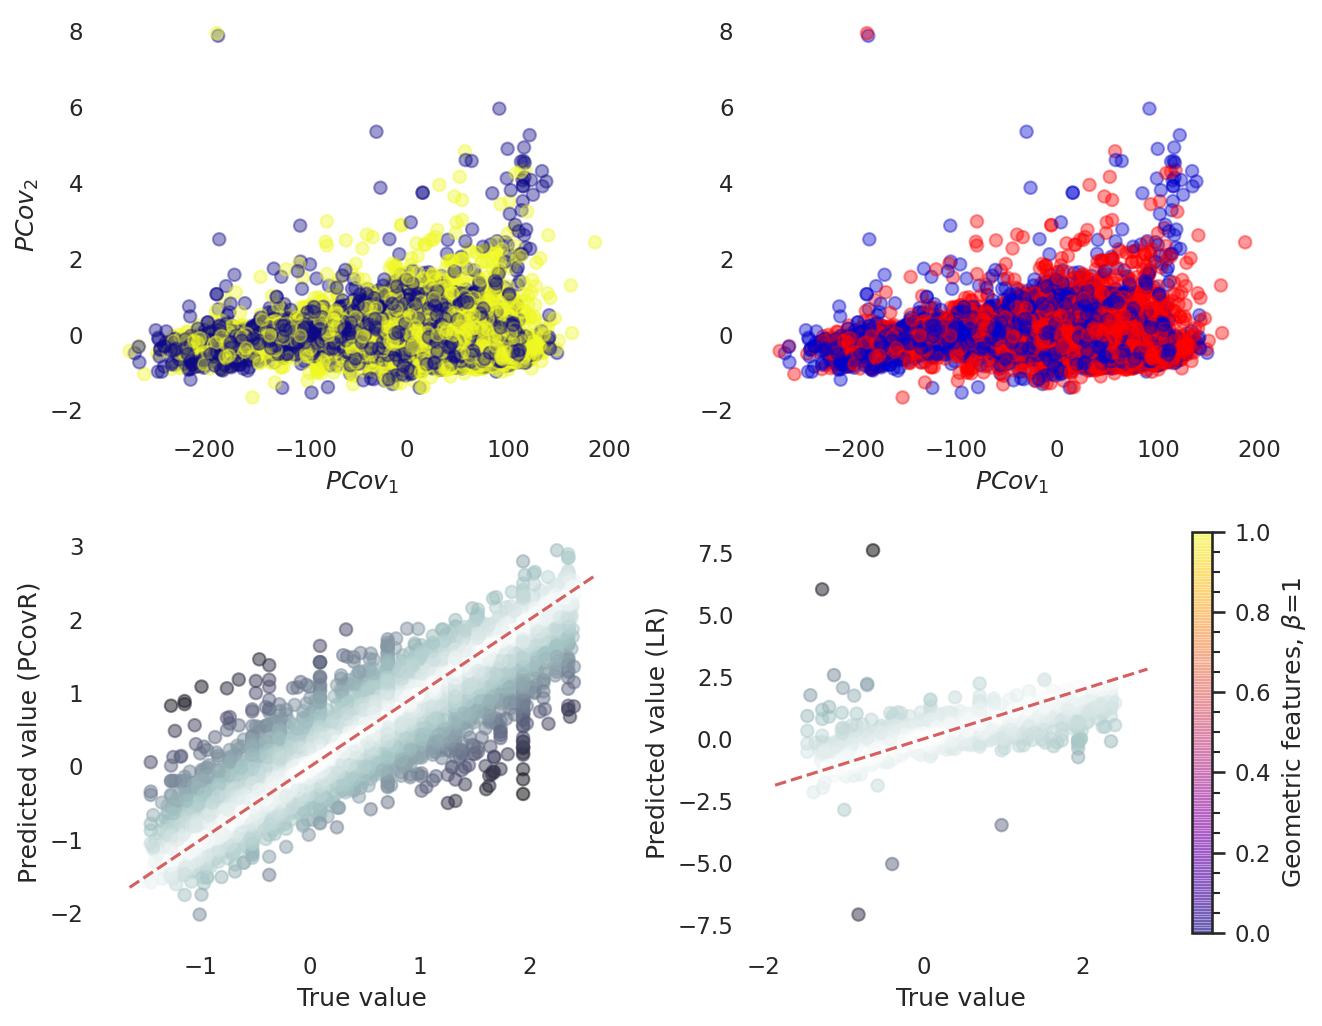

In [18]:
Y_tot=np.vstack((alpha, cn, packing, x)).T
X=np.copy(X_raw)
y_raw=np.copy(Y_tot)
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_raw, train_size=0.8
)

x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
y_scaler = StandardFlexibleScaler(column_wise=False).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)
mix=[0, 0.5, 1]
for g in range(len(mix)):

    pcovr.fit(X,Y)

    T = pcovr.transform(X)
    yp = pcovr.predict(X)


    ridgecv.fit(X_train, y_train)
    yp_test=ridgecv.predict(X_test)
#     fig, ((caxT, caxM),(axT, axM),  (axy, axy_reg), (caxy, caxy_reg)) = plt.subplots(
#         4, 2, figsize=(9,9), gridspec_kw=dict(height_ratios=(0.07, 1, 1, 0.07)))
    fig, ((axT, axM),  (axy, axy_reg)) = plt.subplots(
        2, 2, figsize=(9,7))
    cax = fig.add_axes(axes=axM)

    scatT = axT.scatter(T[:, 0], T[:, 1], alpha=0.4, c=magic, cmap='plasma')
    axT.set_xlabel(r"$PCov_1$")
    axT.set_ylabel(r"$PCov_2$")
    fig.colorbar(scatT, cax=cax, orientation='vertical', 
                 label=str('Geometric features')+r', $\beta$='+str(mix[g]) )

#     fig.colorbar(scatT, cax=caxT, label=titles[i], orientation="horizontal")

    scatM = axM.scatter(T[:, 0], T[:, 1], alpha=0.4, c=magic, cmap = my_c)
    axM.set_xlabel(r"$PCov_1$")
#     fig.colorbar(scatM, cax=caxM, label="magic=1", orientation="horizontal")

    scaty = axy.scatter(Y, yp, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r')
    axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy.set_xlabel(r"True value")
    axy.set_ylabel(r"Predicted value (PCovR)")
#     fig.colorbar(scaty, cax=caxy,label='Error in y', orientation="horizontal")

    scaty_reg=axy_reg.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", alpha=0.5)    
    axy_reg.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy_reg.set_xlabel(r"True value")
    axy_reg.set_ylabel(r"Predicted value (LR)")
#     fig.colorbar(scaty_reg, cax=caxy_reg,label='Error in y', orientation="horizontal")
    sns.despine(left=True, bottom=True)
    fig.tight_layout()

#     print('R^2 with PCovR= ', pcovr.score(X,Y))
#     print('R^2 of testing is with RidgeCV', ridgecv.score(X_test,y_test))
#     print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))
#     print("error in units (eV) of predicted quantity before scaling = ", (max(y_raw)-min(y_raw))*(1-ridgecv.score(X_test,y_test)))
#     print("error in units (eV) of predicted quantity after scaling= ", (max(Y)-min(Y))*(1-ridgecv.score(X_test,y_test)))

    plt.show()
    plt.close()

    data = write_input(
    path='../chem/3dcd'+str(n_frames)+'_beta='+str(mix[g])+'_TOT.json.gz',
    meta={"name": '3dcd'+str(n_frames)+'pcovr_TOT'},
    frames=my_frames,
    properties={
        **{f"PCA_{i+1}": 
            {"target": "structure", 
            "values": T[:, i]} for i in range(n_PC)},
        "magic": {
            "target": "structure",
            "values": magic,
        }, 

         "packing": {
            "target": "structure",
            "values": packing, 
         },
        "alpha": {
            "target": "structure",
            "values": alpha, 
         },
        "x": {
            "target": "structure",
            "values": x, 
         },
        "std_rad": {
            "target": "structure",
            "values": std_ratio, 
         },
        "FCC": {
            "target": "structure",
            "values": fcc, 
         },
         "HCP": {
            "target": "structure",
            "values": hcp, 
         },
         "n_species": {
            "target": "structure",
            "values": n_species, 
         },
    })

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  2.35763398203e+21
R^2 of testing is with RidgeCV 0.762169527705
RMSE on predicted quantity =  0.24021462926
error in units (eV) of predicted quantity before scaling =  [ 0.21496216]
error in units (eV) of predicted quantity after scaling=  [ 0.93992358]


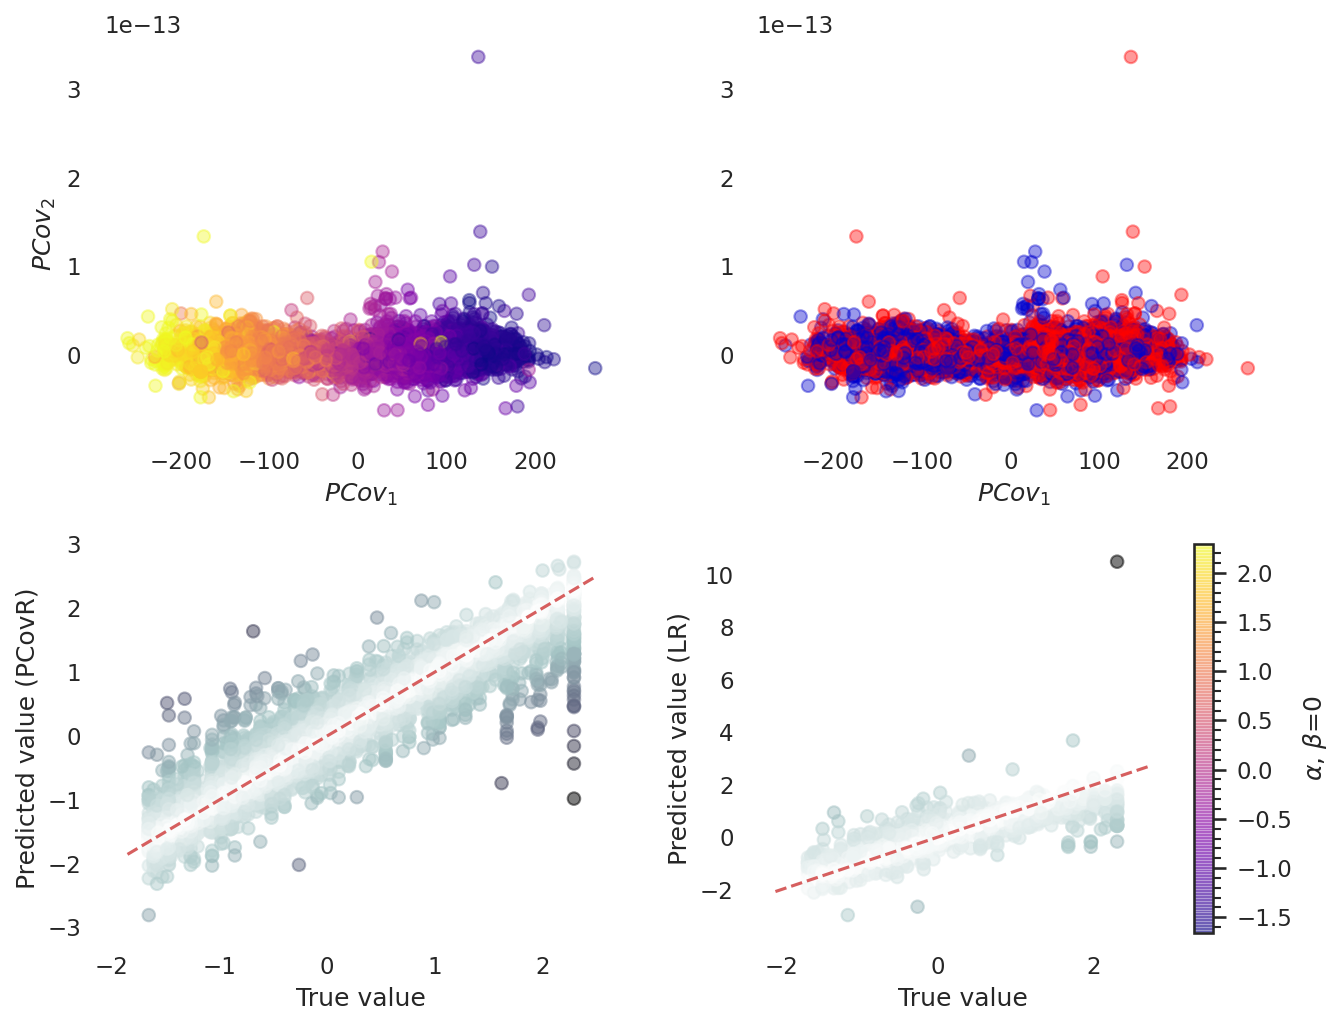

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.92418217013e+21
R^2 of testing is with RidgeCV 0.762169527705
RMSE on predicted quantity =  0.24021462926
error in units (eV) of predicted quantity before scaling =  [ 0.21496216]
error in units (eV) of predicted quantity after scaling=  [ 0.93992358]


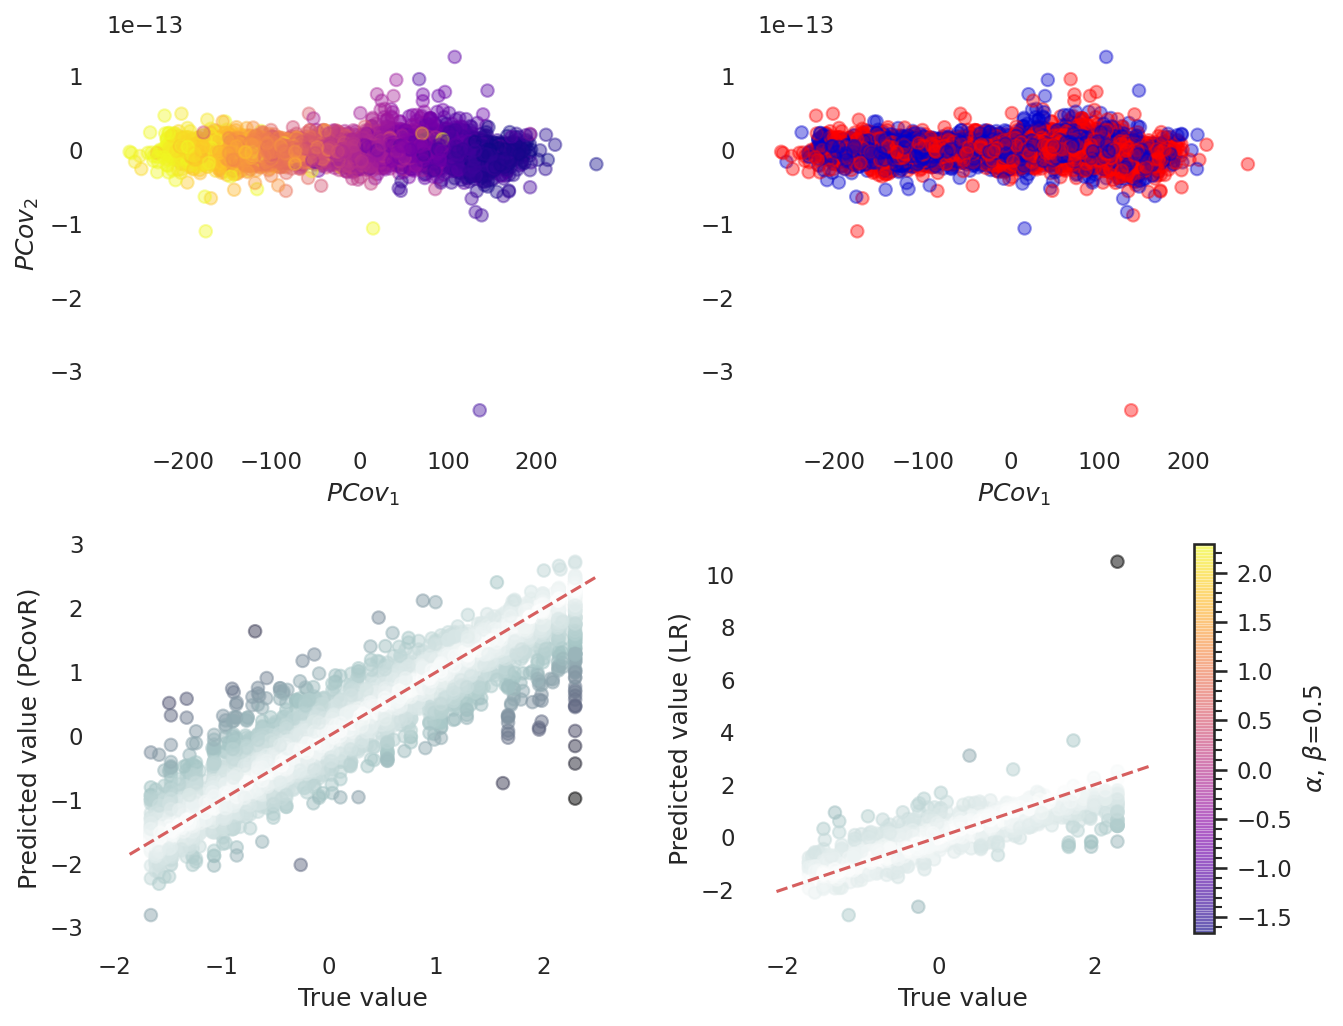

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.20346563508e+21
R^2 of testing is with RidgeCV 0.762169527705
RMSE on predicted quantity =  0.24021462926
error in units (eV) of predicted quantity before scaling =  [ 0.21496216]
error in units (eV) of predicted quantity after scaling=  [ 0.93992358]


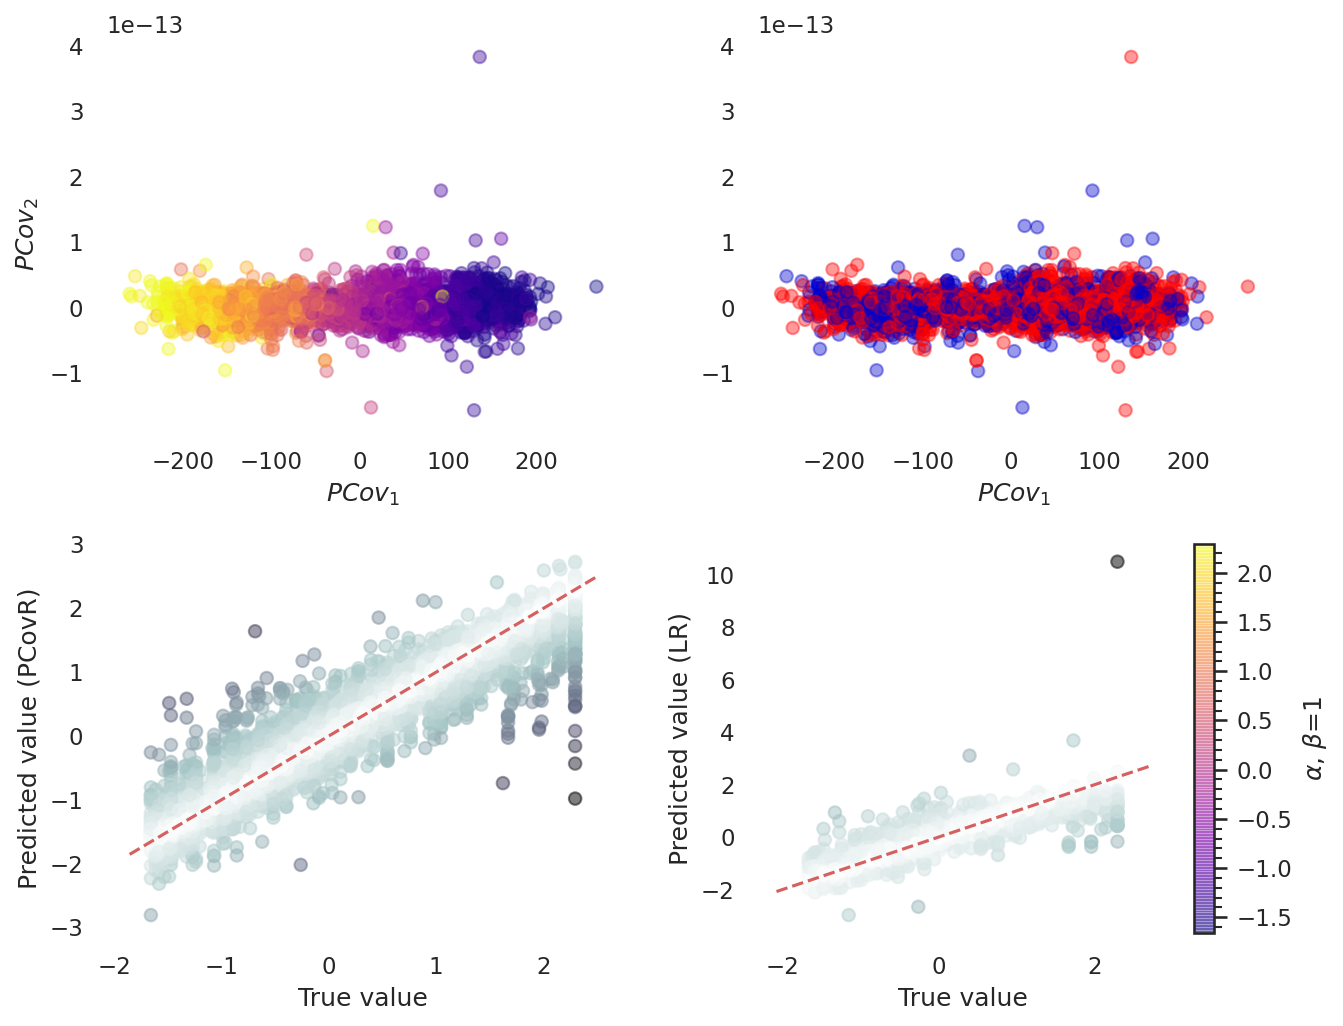

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.27807405335
R^2 of testing is with RidgeCV 0.273096182754
RMSE on predicted quantity =  0.7517675181
error in units (eV) of predicted quantity before scaling =  [ 0.71512727]
error in units (eV) of predicted quantity after scaling=  [ 3.6520676]


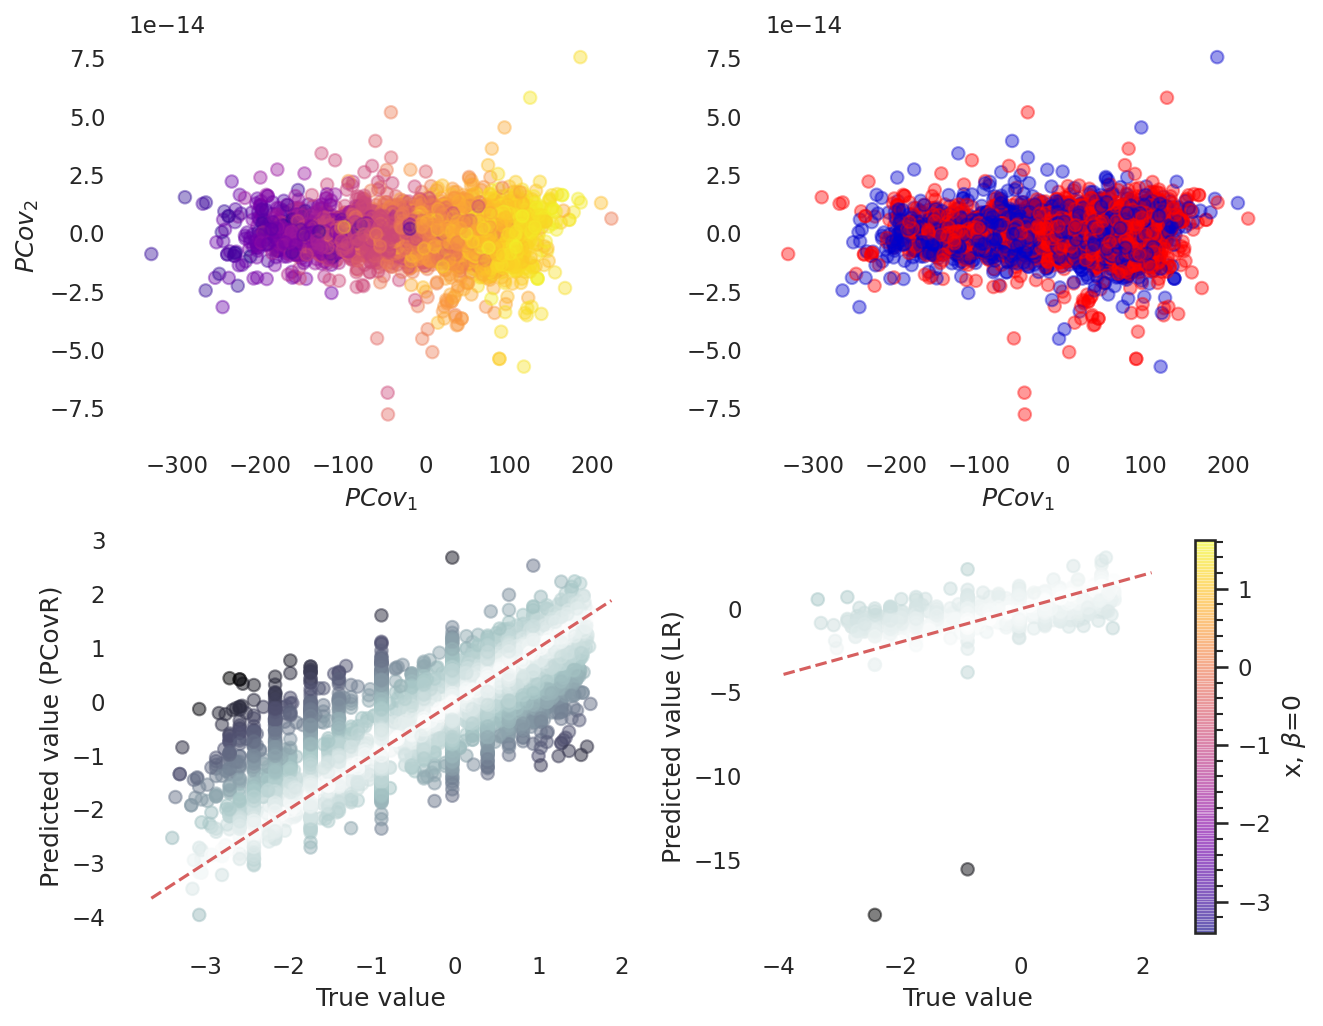

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.27807026773
R^2 of testing is with RidgeCV 0.273096182754
RMSE on predicted quantity =  0.7517675181
error in units (eV) of predicted quantity before scaling =  [ 0.71512727]
error in units (eV) of predicted quantity after scaling=  [ 3.6520676]


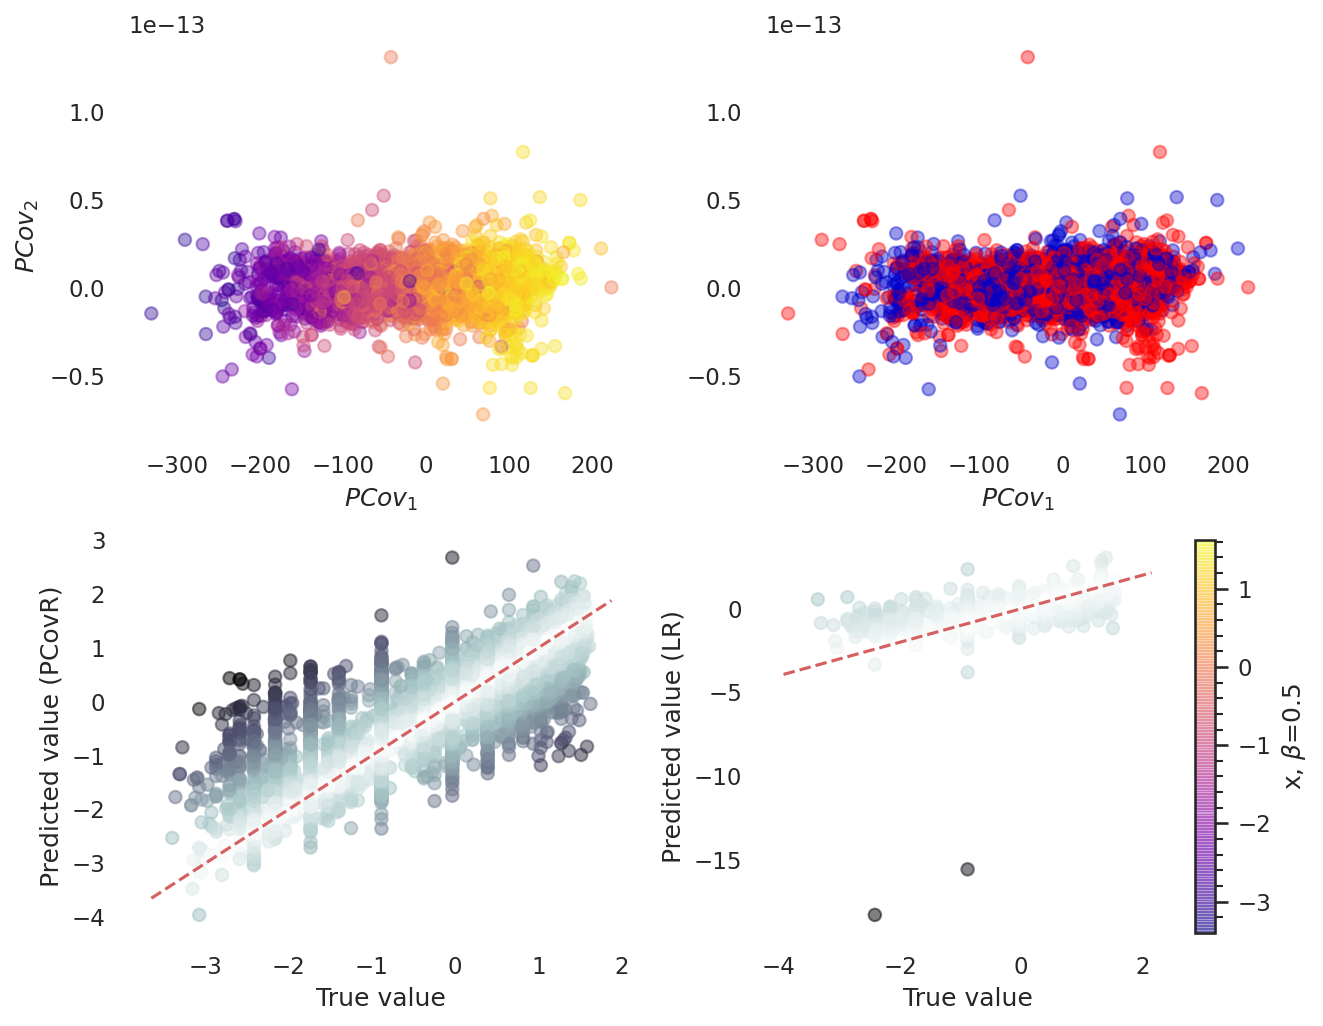

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.27807407356
R^2 of testing is with RidgeCV 0.273096182754
RMSE on predicted quantity =  0.7517675181
error in units (eV) of predicted quantity before scaling =  [ 0.71512727]
error in units (eV) of predicted quantity after scaling=  [ 3.6520676]


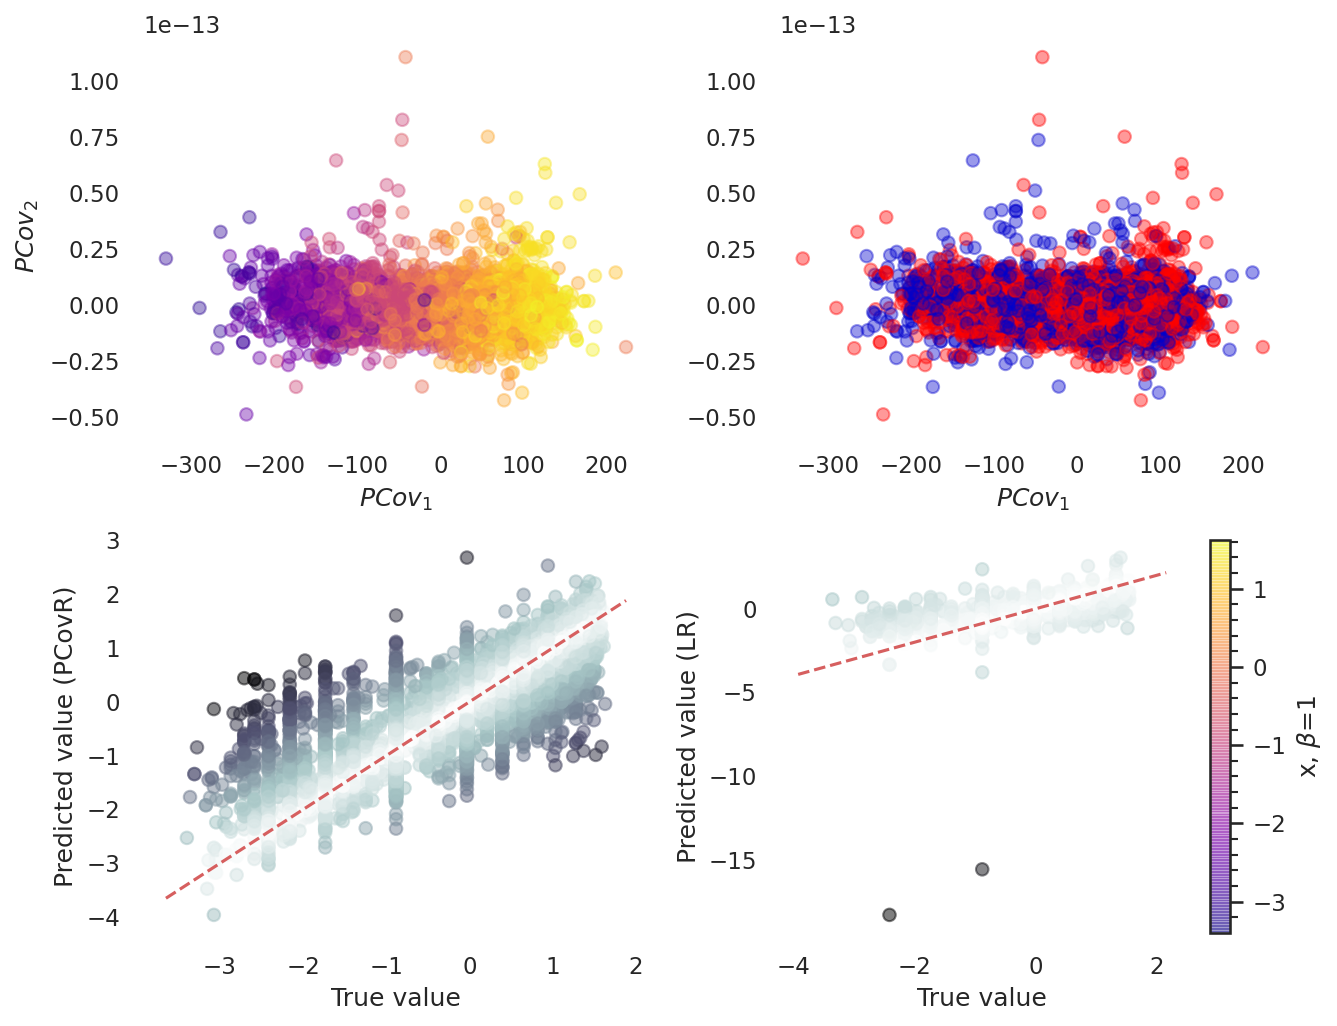

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.84796194226e+23
R^2 of testing is with RidgeCV 0.733928003912
RMSE on predicted quantity =  0.266146452753
error in units (eV) of predicted quantity before scaling =  [ 1.18193346]
error in units (eV) of predicted quantity after scaling=  [ 4.09226045]


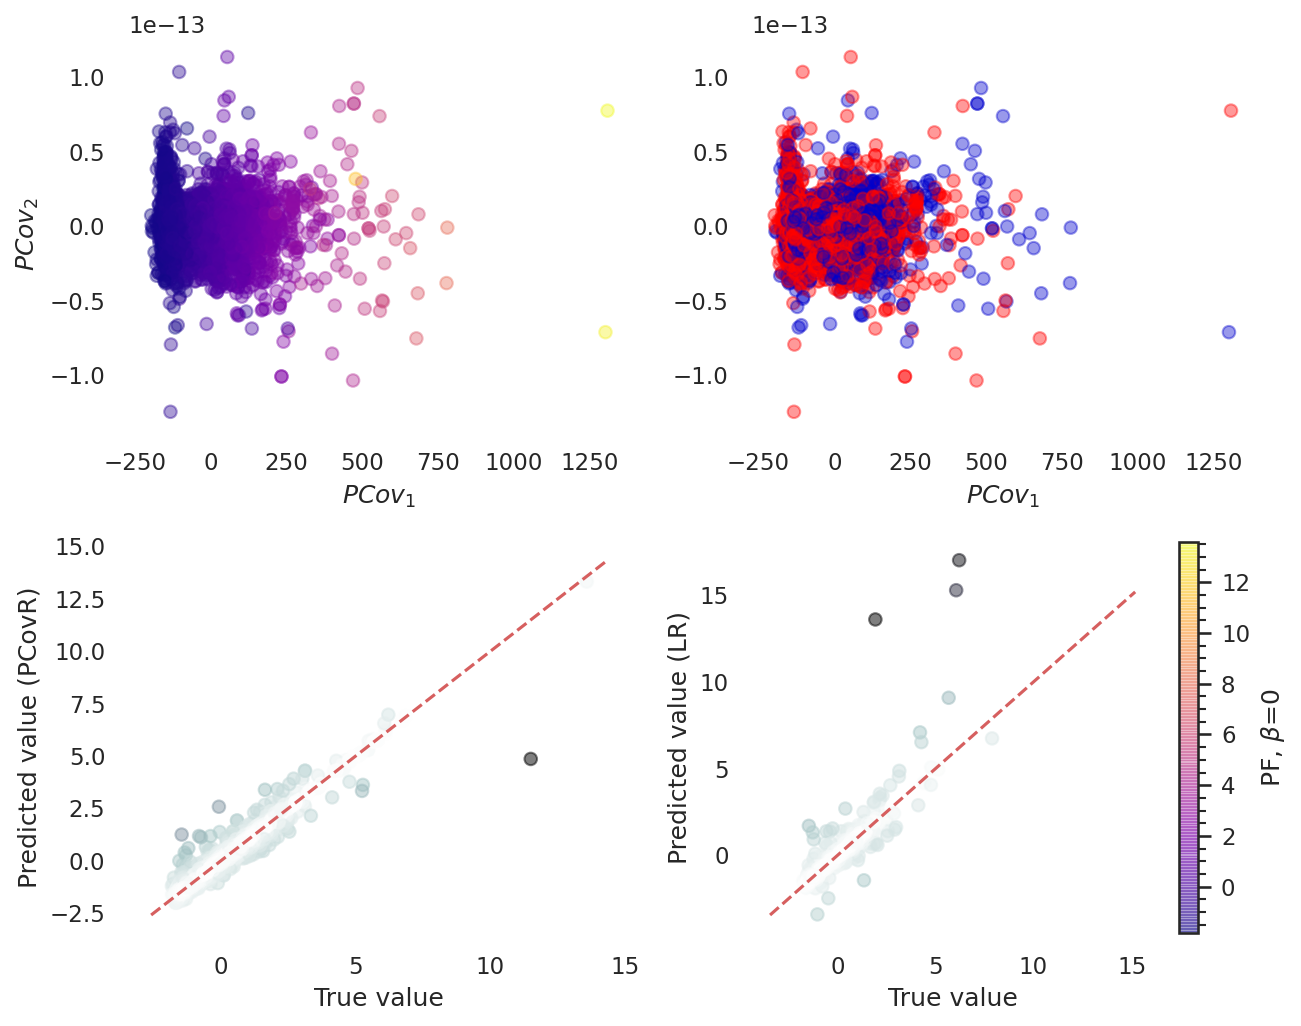

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.02561067172
R^2 of testing is with RidgeCV 0.733928003912
RMSE on predicted quantity =  0.266146452753
error in units (eV) of predicted quantity before scaling =  [ 1.18193346]
error in units (eV) of predicted quantity after scaling=  [ 4.09226045]


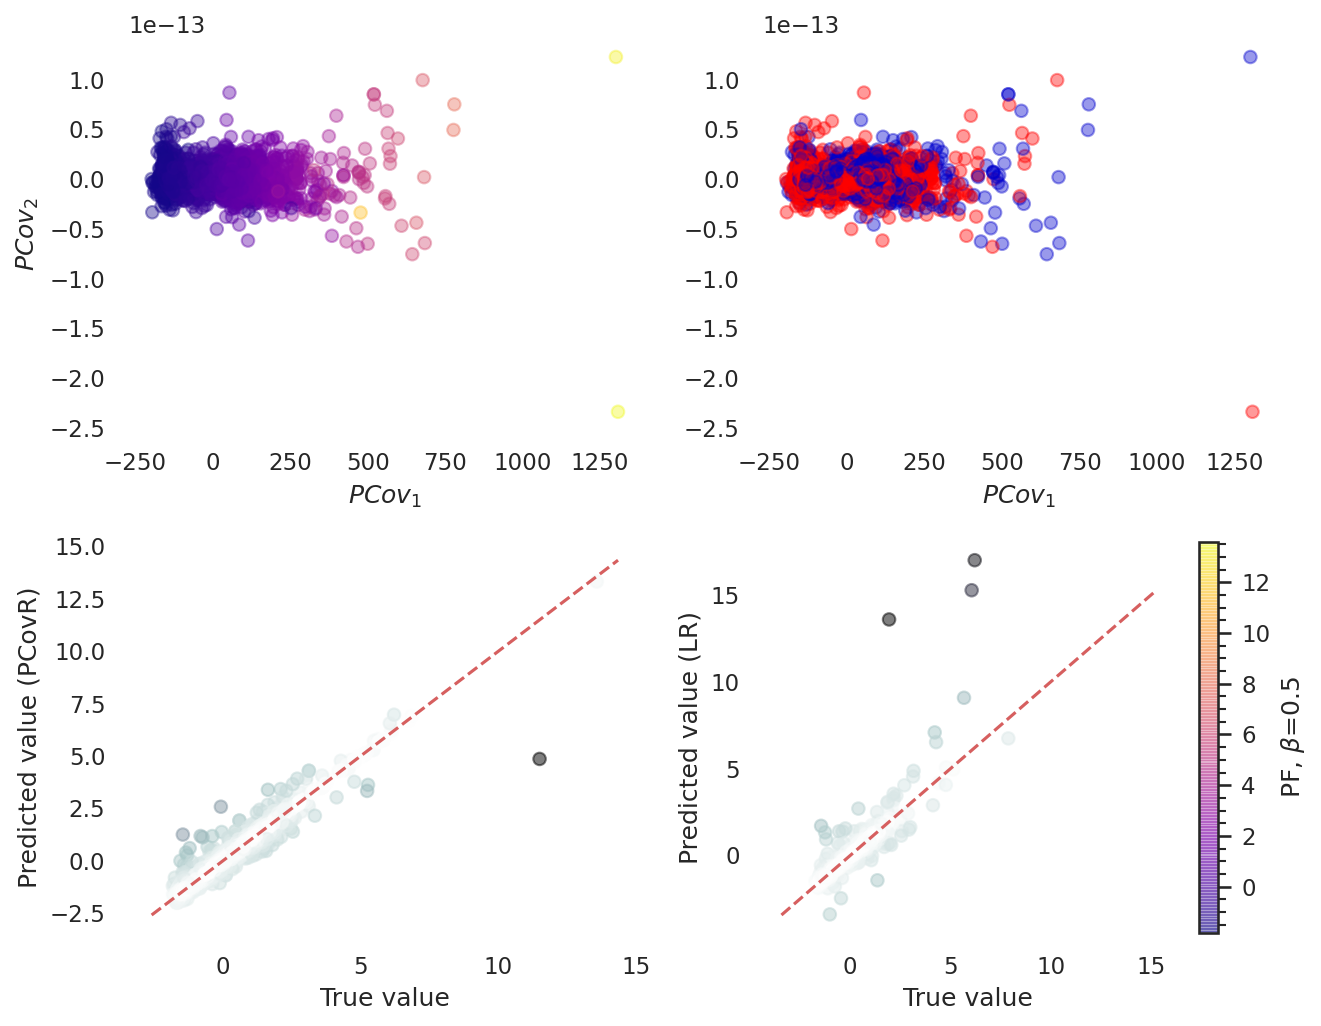

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.28938964455e+24
R^2 of testing is with RidgeCV 0.733928003912
RMSE on predicted quantity =  0.266146452753
error in units (eV) of predicted quantity before scaling =  [ 1.18193346]
error in units (eV) of predicted quantity after scaling=  [ 4.09226045]


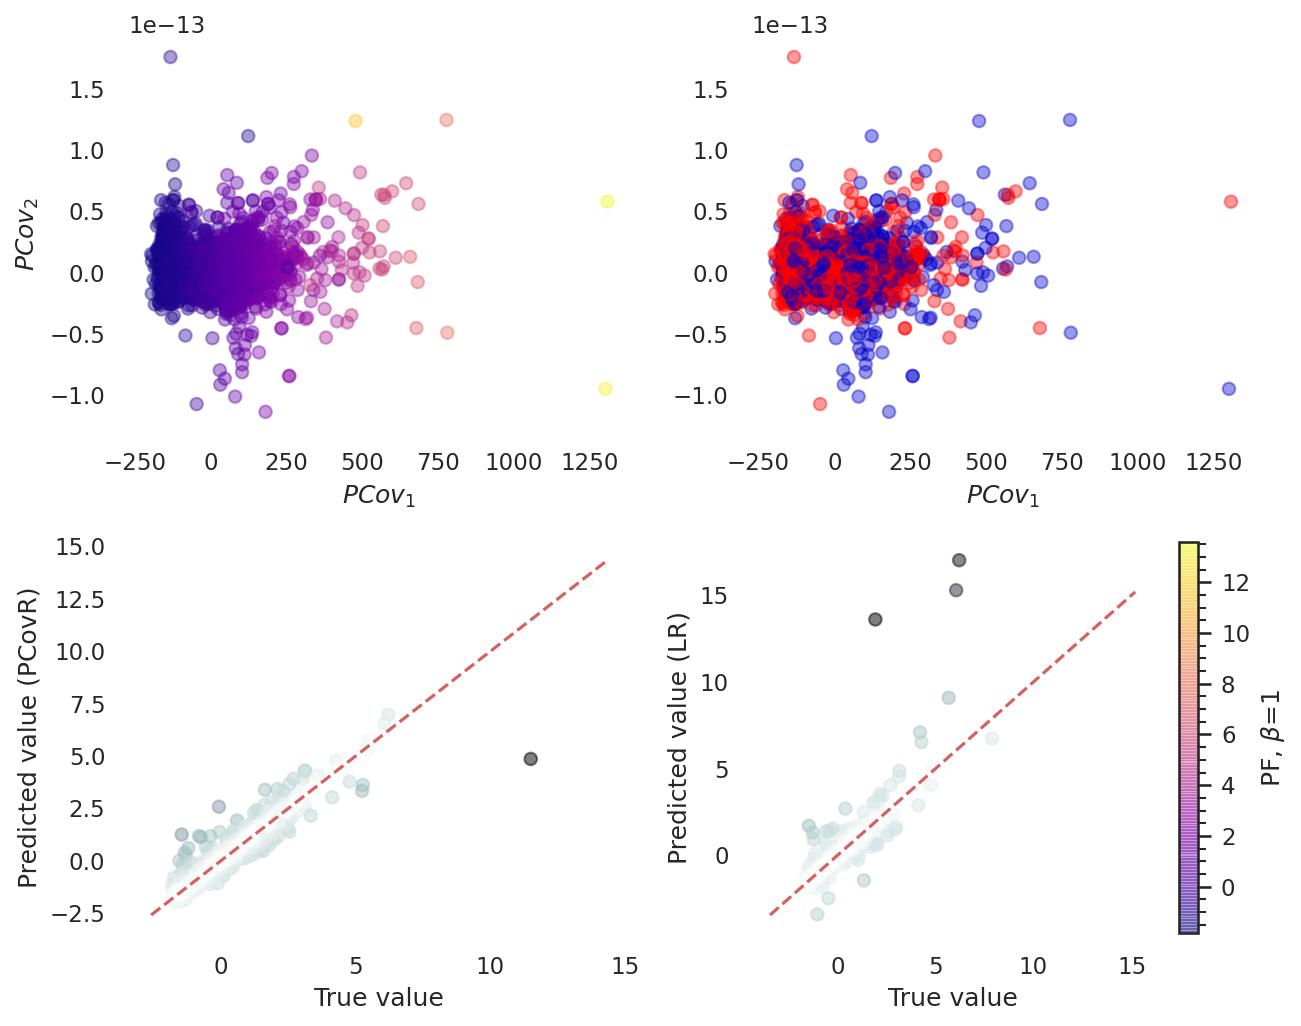

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.10392457763
R^2 of testing is with RidgeCV 0.644420620752
RMSE on predicted quantity =  0.357228065968
error in units (eV) of predicted quantity before scaling =  [ 4.44474224]
error in units (eV) of predicted quantity after scaling=  [ 1.38442708]


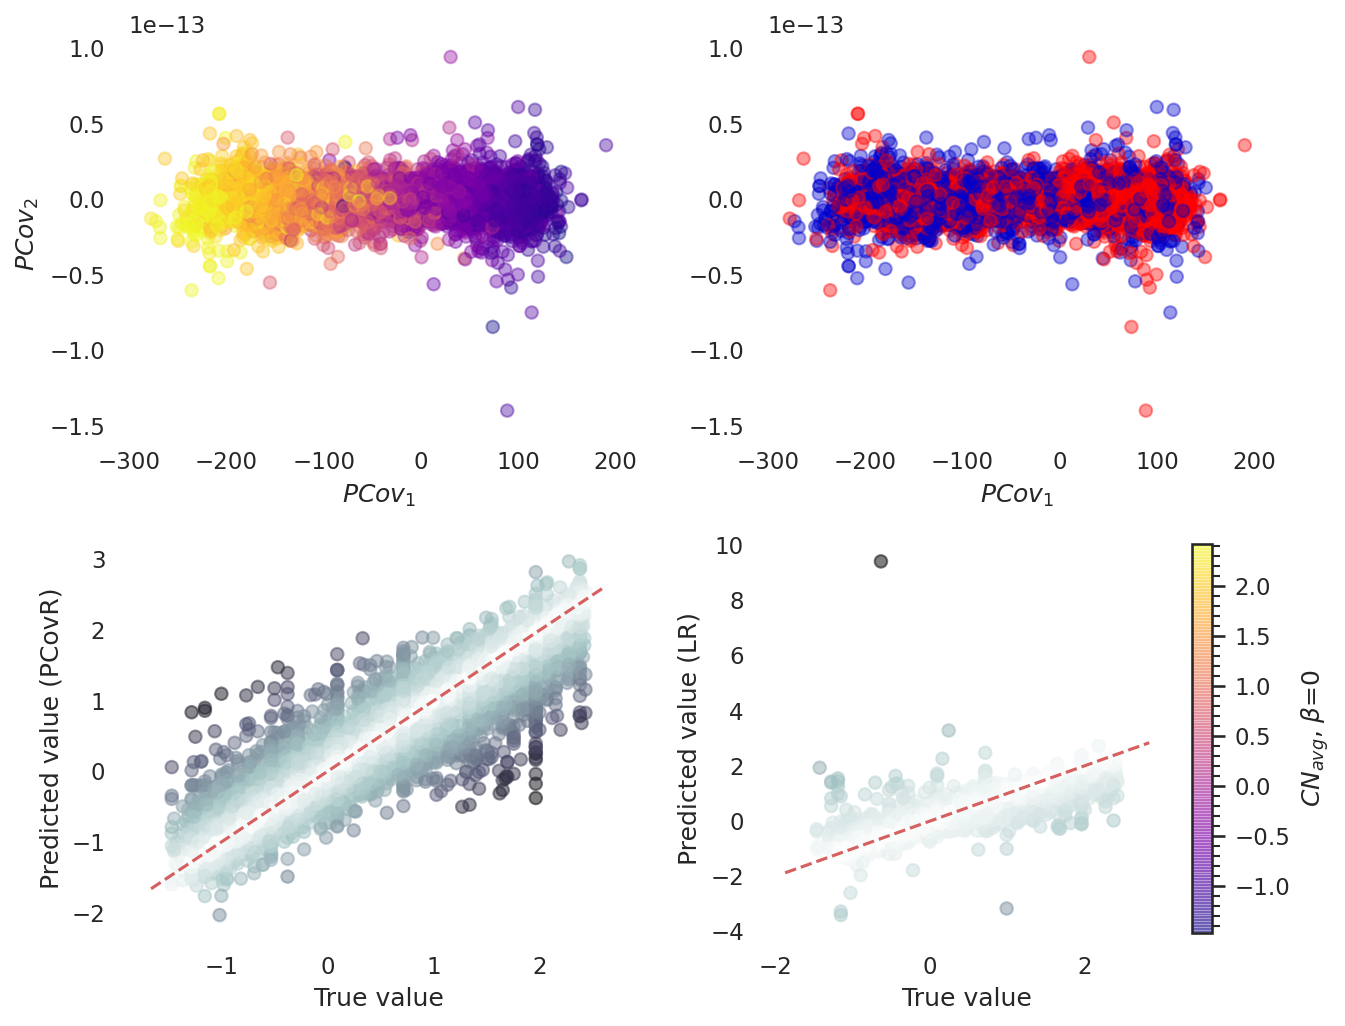

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.10389017852
R^2 of testing is with RidgeCV 0.644420620752
RMSE on predicted quantity =  0.357228065968
error in units (eV) of predicted quantity before scaling =  [ 4.44474224]
error in units (eV) of predicted quantity after scaling=  [ 1.38442708]


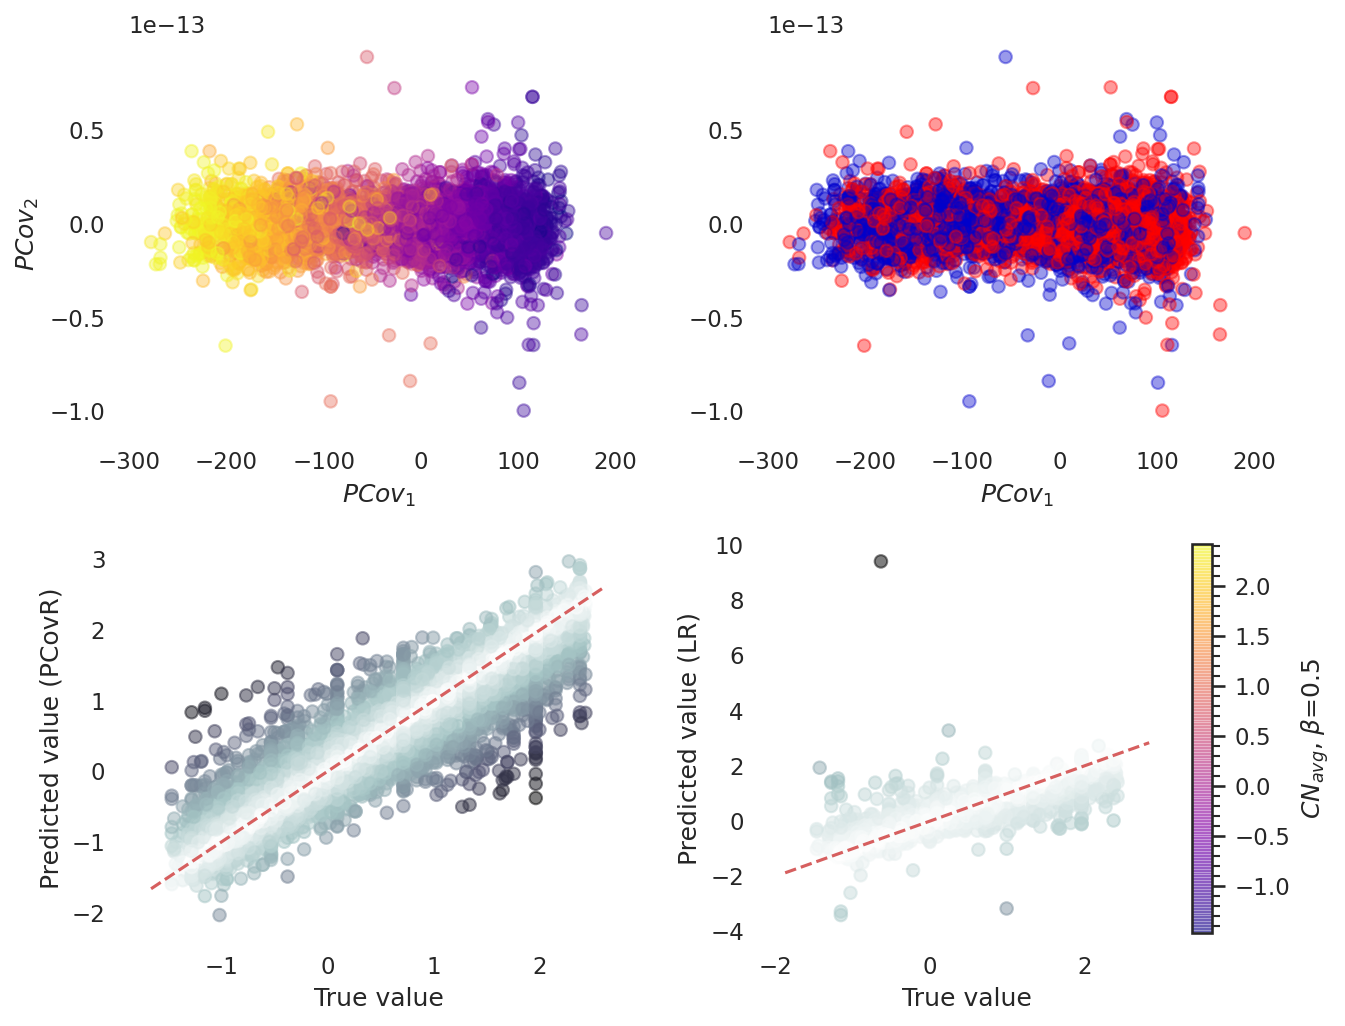

<ipython-input-19-db2d8a646408>:37: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  cax = fig.add_axes()


R^2 with PCovR=  1.10389017852
R^2 of testing is with RidgeCV 0.644420620752
RMSE on predicted quantity =  0.357228065968
error in units (eV) of predicted quantity before scaling =  [ 4.44474224]
error in units (eV) of predicted quantity after scaling=  [ 1.38442708]


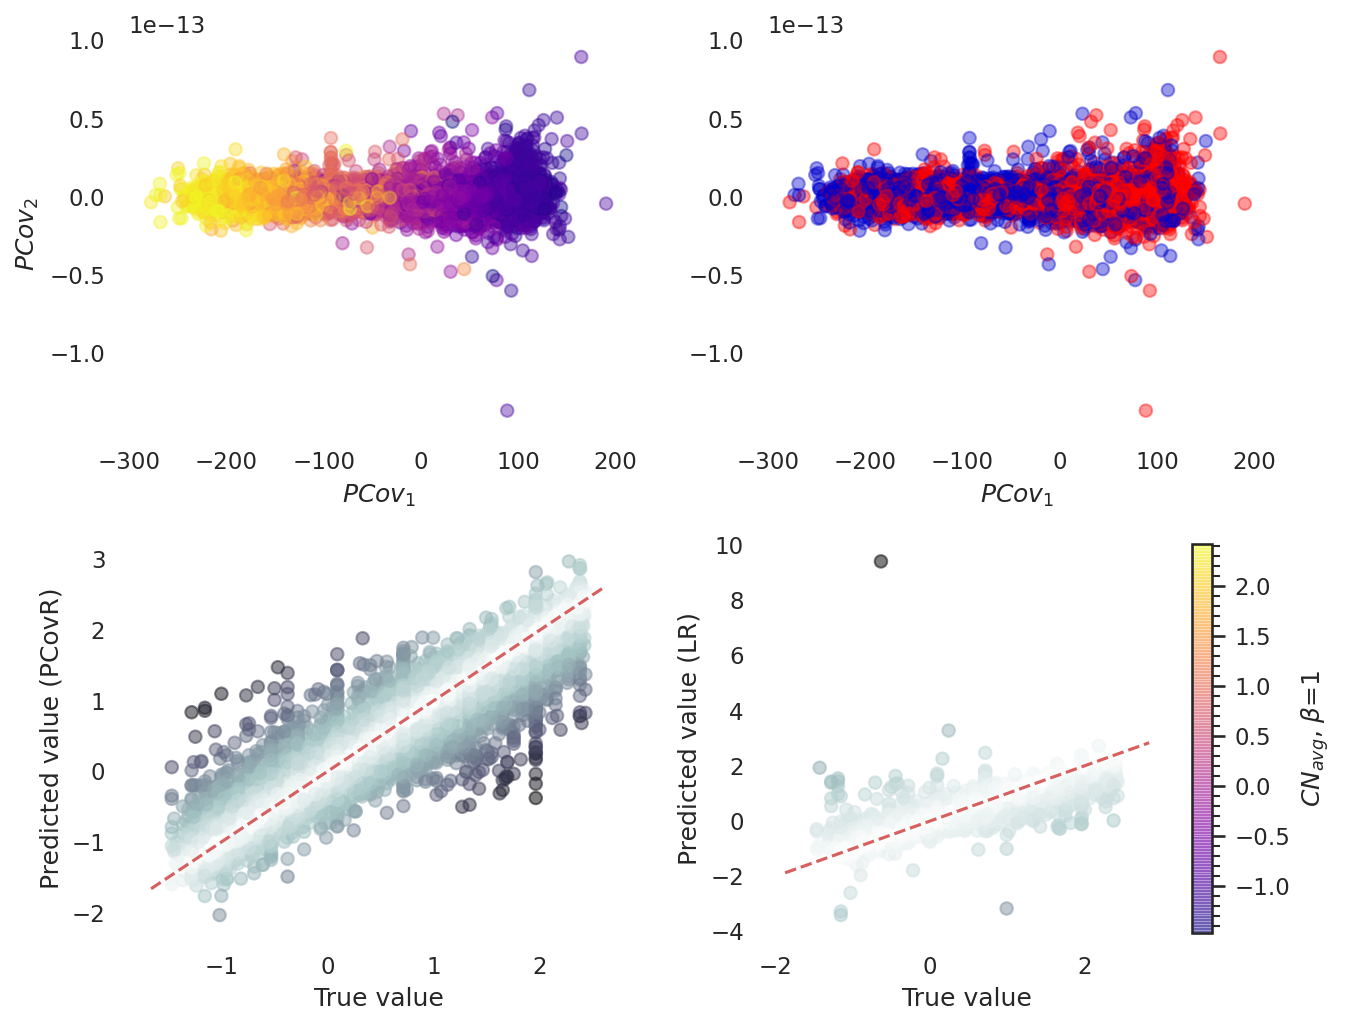

array([  4.,  54.,  14., ...,   9.,  32.,  10.])